## Pré-processamento

In [156]:
import pandas as pd
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd
import string
from sklearn.model_selection import train_test_split
#import spacy

df = pd.read_csv('factnews_dataset.csv')

#criar grupo treino e teste
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

stop_words = set(stopwords.words('portuguese'))

#criar coluna tokens
train_df['tokens'] = train_df['sentences'].apply(lambda x: nltk.word_tokenize(str(x).lower()))

# Tokenizar sem stopwords
train_df['tokens_no_stopwords'] = train_df['tokens'].apply(lambda toks: [t for t in toks if t not in stop_words])

#tirar exemplos da classe 0 para nivelar
classe0 = train_df[train_df['classe'] == 0]
classe0 = classe0.sample(n=443, random_state=42)
outras_classes = train_df[train_df['classe'] != 0]
train_df = pd.concat([outras_classes, classe0]).reset_index(drop=True)
print(train_df['classe'].value_counts())


classe
-1    1115
 1     443
 0     443
Name: count, dtype: int64


## Análise exploratória

In [157]:
# Contar número de linhas por classe
contagem_classes = train_df['classe'].value_counts()
print(contagem_classes)


classe
-1    1115
 1     443
 0     443
Name: count, dtype: int64


Detetar palavras únicas entre as classes

In [158]:
classes = df['classe'].unique()

def palavras_unicas_por_classe(df, token_col):
    
    # contar tokens por classe
    tokens_por_classe = {}
    for classe in classes:
        linhas_classe = df[df['classe'] == classe][token_col].dropna()
        contagem = {}
        for lista in linhas_classe:
            for token in lista:
                if token in contagem:
                    contagem[token] += 1
                else:
                    contagem[token] = 1
        tokens_por_classe[classe] = contagem

    # detetar palavras exclusivas por classe
    palavras_unicas = {}
    for classe in classes:
        # lista de palavras das outras classes
        outras_palavras = []
        for outra_classe in classes:
            if outra_classe != classe:
                for token in tokens_por_classe[outra_classe]:
                    outras_palavras.append(token)

        # dicionário palavras exclusivas com contagens
        unicas_classe = {}
        for palavra, contagem in tokens_por_classe[classe].items():
            exclusiva = True
            for p in outras_palavras:
                if p == palavra:
                    exclusiva = False
                    break
            if exclusiva:
                unicas_classe[palavra] = contagem

        palavras_unicas[classe] = unicas_classe

        ordenadas = dict(sorted(unicas_classe.items(), key=lambda item: item[1], reverse=True)[:10])

        palavras_unicas[classe] = ordenadas

    return palavras_unicas

print(palavras_unicas_por_classe(train_df,'tokens'))


{-1: {'eu': 122, ']': 48, '[': 47, 'gente': 33, 'meu': 31, 'me': 24, 'vamos': 20, '...': 19, '!': 18, 'povo': 18}, 0: {'presos': 7, 'negou': 5, 'defende': 5, 'm': 5, 'posse': 5, 'irá': 4, 'principais': 4, 'lista': 4, 'oficial': 4, 'crimes': 4}, 1: {'maracanã': 9, 'kaká': 7, 'chinaglia': 6, 'atacante': 6, 'vagner': 5, 'ronaldinho': 5, 'marcação': 5, 'desgaste': 5, 'escolha': 4, 'bolsonarista': 4}}


ver a proporção de advérbios e adjetivos entre as classes

In [159]:
nltk.download('mac_morpho') 
from nltk.corpus import mac_morpho

dic_palavras = {}  # Dic para palavras de cada classe gramatical
for palavra, tag in mac_morpho.tagged_words():  # (palavra, tag)
    if tag not in dic_palavras: 
        dic_palavras[tag] = set()
    dic_palavras[tag].add(palavra.lower())  # associar palavra à respetiva tag

print (dic_palavras)

[nltk_data] Downloading package mac_morpho to
[nltk_data]     C:\Users\didia\AppData\Roaming\nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


{'N': {'armazenagem', 'pouso', 'urologista', 'alternativo', 'imprecisões', 'livro-reportagem', 'citocinas', 'maldades', 'custódia', 'tropas', 'ícones', 'militância', 'casinhas', 'sólidos', 'braço-direito', 'secretário-chefe', 'cut', 'desbaste', 'tropismo', 'individual', 'criançada', 'desníveis', 'ocorrências', 'comédias', 'plantel', 'secadores', 'alter-ego', 'regionalismos', 'médias', 'contextos', 'capas', 'goleiro', 'nevada', 'jeca', 'premissa', 'arquétipo', 'ultrapassagem', 'cupons', 'mar', 'pirâmide', 'criancinhas', 'ps', 'agrária', 'escrivã', 'morrinhos', 'papillon', 'mãozinha', 'colaboradores', 'hipoclorito', 'crested', 'repentistas', 'emancipação', 'lantejoulas', 'candeeiro', 'trigal', 'desastre', 'pico', 'clássicos', 'reequilíbrio', 'campeão', 'oitava-de-final', 'travamento', 'elétrons', 'detentora', 'diretas', 'alegrias', '1908', 'convidado', 'desconstruções', 'incitador', 'coalizões', 'torneiros', 'bisturi', 'imigrantes', 'onanistas', 'nepotismos', 'primórdios', 'consoles', 'e

Ver todos os tipos de token presentes no dataset

In [160]:
print(dic_palavras.keys())

dict_keys(['N', 'V', 'PREP', 'CUR', 'NUM', 'PREP|+', 'ART', 'NPROP', 'PROADJ', ',', 'PRO-KS-REL', 'N|AP', 'ADJ', 'KC', 'VAUX', '(', ')', 'KS', '"', 'PCP', 'ADV', 'PROPESS', 'V|+', 'PDEN', 'PROSUB', '-', ':', 'PRO-KS', 'VAUX|+', 'ADV-KS-REL', '$', 'N|HOR', ';', 'ART|+', '[', 'ADJ|EST', 'N|EST', 'N|TEL', 'N|DAT', 'KC|[', 'KC|]', '?', '!', 'ADV|[', 'ADV|]', 'ADV-KS', 'ADV|+', 'NUM|TEL', '.', 'IN', "'", '/', 'PREP|[', 'PREP|]', 'NPROP|+', 'PREP|', 'NPRO', 'ADV|EST', '...', 'N|DAD', '=', 'VAUX|!', 'ADV|HOR', 'ADJ|+', 'ART|EST', 'PREP|+]', 'PROP', 'V|EST', 'PREP|EST', 'KC|EST', 'PROADJ|+', 'KS|[', 'KS|]', 'IN|EST', 'PROPESS|EST', 'PDEN|EST', '((', '))', '`', 'PROPESS|+', 'KC|+', 'V|!'])


In [161]:
def proporcao_adverbios_adjetivos_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()  
    proporcoes_por_classe = {}     

    lista_adverbios = dic_palavras.get('ADV', set())  
    lista_adjetivos = dic_palavras.get('ADJ', set())  
    lista_modais = dic_palavras.get('MD', set())
    
    for classe in classes: 
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()  
            
        total_adverbios_classe = 0   
        total_adjetivos_classe = 0    
        total_modais_classe = 0
        total_tokens_classe = 0

        # contar advérbios e adjetivos
        for lista_tokens in tokens_por_classe:
            total_adverbios_classe += sum(1 for token in lista_tokens if token in lista_adverbios)
            total_adjetivos_classe += sum(1 for token in lista_tokens if token in lista_adjetivos)
            total_modais_classe += sum(1 for token in lista_tokens if token in lista_modais)
            total_tokens_classe += len(lista_tokens)

        proporcoes_por_classe[classe] = {
            'total_adverbios': total_adverbios_classe,
            'media_adverbios_por_token': total_adverbios_classe / total_tokens_classe,
            'total_adjetivos': total_adjetivos_classe,
            'media_adjetivos_por_token': total_adjetivos_classe / total_tokens_classe,
            'total_modais': total_modais_classe,
            'media_modais_por_token': total_modais_classe / total_tokens_classe,
        }
    
    return proporcoes_por_classe

proporcao_adverbios_adjetivos_por_classe(train_df, 'tokens')

{-1: {'total_adverbios': 7702,
  'media_adverbios_por_token': 0.3276331461630083,
  'total_adjetivos': 4684,
  'media_adjetivos_por_token': 0.19925131870001703,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 1: {'total_adverbios': 3964,
  'media_adverbios_por_token': 0.3465034965034965,
  'total_adjetivos': 2278,
  'media_adjetivos_por_token': 0.19912587412587412,
  'total_modais': 0,
  'media_modais_por_token': 0.0},
 0: {'total_adverbios': 3383,
  'media_adverbios_por_token': 0.3175631277574392,
  'total_adjetivos': 2095,
  'media_adjetivos_por_token': 0.196658218342251,
  'total_modais': 0,
  'media_modais_por_token': 0.0}}

In [162]:
def proporcao_palavras_por_classe(df, coluna_tokens):
    classes = df['classe'].unique()
    proporcoes_por_classe = {}

    for classe in classes:
        tokens_por_classe = df[df['classe'] == classe][coluna_tokens].dropna()
        total_tokens_classe = sum(len(lista) for lista in tokens_por_classe)
        proporcoes_por_classe[classe] = {}

        for key in dic_palavras.keys():
            lista_tokens_tag = dic_palavras.get(key, set())
            total_palavras_tag = sum(
                1 for lista_tokens in tokens_por_classe for token in lista_tokens if token in lista_tokens_tag
            )
            if total_palavras_tag > 0:
                proporcoes_por_classe[classe][key] = {
                    'total': total_palavras_tag,
                    'media_por_token': total_palavras_tag / total_tokens_classe if total_tokens_classe else 0
                }

    return proporcoes_por_classe

resultados = proporcao_palavras_por_classe(train_df, 'tokens')

discrepancias = {}

for key in dic_palavras.keys():
    media_0 = resultados.get(0, {}).get(key, {}).get('media_por_token', 0)
    media_1 = resultados.get(1, {}).get(key, {}).get('media_por_token', 0)
    discrepancia = abs(media_0 - media_1)
    discrepancias[key] = (discrepancia, media_0, media_1)

chaves_ordenadas = sorted(discrepancias, key=lambda k: discrepancias[k][0], reverse=True)[:10]

for k in chaves_ordenadas:
    discrepancia, media_0, media_1 = discrepancias[k]
    print(f"{k}: classe 0 = {media_0:.4f}, classe 1 = {media_1:.4f}, diferença = {discrepancia:.4f}")

print(chaves_ordenadas)


ADV: classe 0 = 0.3176, classe 1 = 0.3465, diferença = 0.0289
PROSUB: classe 0 = 0.1558, classe 1 = 0.1816, diferença = 0.0257
KC: classe 0 = 0.1449, classe 1 = 0.1684, diferença = 0.0234
KS: classe 0 = 0.2519, classe 1 = 0.2728, diferença = 0.0209
V: classe 0 = 0.2042, classe 1 = 0.2233, diferença = 0.0192
PROADJ: classe 0 = 0.1139, classe 1 = 0.1330, diferença = 0.0191
NPROP: classe 0 = 0.7083, classe 1 = 0.6925, diferença = 0.0159
N: classe 0 = 0.5887, classe 1 = 0.5997, diferença = 0.0111
PREP: classe 0 = 0.3407, classe 1 = 0.3511, diferença = 0.0105
PROPESS: classe 0 = 0.0957, classe 1 = 0.1062, diferença = 0.0105
['ADV', 'PROSUB', 'KC', 'KS', 'V', 'PROADJ', 'NPROP', 'N', 'PREP', 'PROPESS']


## Contruir regras para classificar o texto

Classificar Versão 1

In [163]:
def citacao(text):
    return '"' in str(text) or '“' in str(text) or '”' in str(text) or '[' in str(text) 

def bias(text):
    return '?' in str(text)

def classificar(row):
    if citacao(row['sentences']):
        return -1  
    if bias(row['sentences']):
        return 1
    return 0

Classificar Versão 2

In [164]:
palavras_unicas = palavras_unicas_por_classe(train_df,'tokens')

def classificar_texto(row):
    texto = row['sentences'].lower()
    tokens_texto = nltk.word_tokenize(texto)
    tokens_set = set(tokens_texto)

    for classe, palavras_contagem in palavras_unicas.items():
        for palavra in palavras_contagem.keys():
            if palavra in tokens_set: 
                return classe

    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }
    #citacao
    if '"' in texto or '“' in texto or '”' in texto or "'" in texto or "[" in texto:
        return -1
    if any(verbo in texto for verbo in ['disse', 'afirmou', 'relatou', 'segundo', 'comentou']):
        pontos['citacao'] += 1
        

    #bias
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {
        'citacao': -1,
        'facto': 0,
        'bias': 1,
    }
    
    return mapa_classes[classe_max]


Classificar Versão 3

In [165]:
'''import spacy
import re

nlp = spacy.load("pt_core_news_sm")

def classificar_texto2(row, medias, chaves):
    texto = row['sentences'].lower()
    doc = nlp(texto)
    tags = [token.pos_ for token in doc]
    total_tokens = len(tags) 
    pontos = {
        'citacao': 0,
        'bias': 0,
        'facto': 0
    }

    # Citacao
    if any(p in texto for p in ['"', '“', '”', "'", '[']):
        pontos['citacao'] += 2

    # Bias - estas regras de palavras podemos substituir pelas palavras unicas
    if any(adj in texto for adj in ['horrível', 'bom', 'terrível', 'excelente', 'injusto', 'desejável']):
        pontos['bias'] += 2
    if any(intens in texto for intens in ['muito', 'claramente', 'extremamente', 'realmente']):
        pontos['bias'] += 1
    if '?' in texto:
        pontos['bias'] += 1

    #a cena das médias
    for key in chaves:
        media_0 = medias.get(0, {}).get(key, {}).get('media_por_token', 0)
        media_1 = medias.get(1, {}).get(key, {}).get('media_por_token', 0)
        meio = (media_0 + media_1) / 2

        valor_frase = tags.count(key) / total_tokens

        if valor_frase >= meio:
            if media_0 < media_1:   
                pontos['bias'] += 1
            else:
                pontos['facto'] += 1 
        else:
            if media_1 < media_0:
                pontos['facto'] += 1
            else:
                pontos['bias'] += 1
    # Factos
    if re.search(r'\b(milhões|milhares|ano|anos|percentagem|por cento|%|dados|número|quantidade)\b', texto):
        pontos['facto'] += 2
    if any(verbo in texto for verbo in ['foi', 'são', 'estarão', 'está', 'ficou', 'ocorreu']):
        pontos['facto'] += 1

    classe_max = max(pontos, key=pontos.get)
    mapa_classes = {'citacao': -1, 'facto': 0, 'bias': 1}
    return mapa_classes[classe_max]'''


'import spacy\nimport re\n\nnlp = spacy.load("pt_core_news_sm")\n\ndef classificar_texto2(row, medias, chaves):\n    texto = row[\'sentences\'].lower()\n    doc = nlp(texto)\n    tags = [token.pos_ for token in doc]\n    total_tokens = len(tags) \n    pontos = {\n        \'citacao\': 0,\n        \'bias\': 0,\n        \'facto\': 0\n    }\n\n    # Citacao\n    if any(p in texto for p in [\'"\', \'“\', \'”\', "\'", \'[\']):\n        pontos[\'citacao\'] += 2\n\n    # Bias - estas regras de palavras podemos substituir pelas palavras unicas\n    if any(adj in texto for adj in [\'horrível\', \'bom\', \'terrível\', \'excelente\', \'injusto\', \'desejável\']):\n        pontos[\'bias\'] += 2\n    if any(intens in texto for intens in [\'muito\', \'claramente\', \'extremamente\', \'realmente\']):\n        pontos[\'bias\'] += 1\n    if \'?\' in texto:\n        pontos[\'bias\'] += 1\n\n    #a cena das médias\n    for key in chaves:\n        media_0 = medias.get(0, {}).get(key, {}).get(\'media_por_to

ver verbo verbo numa frase - prob um bias

## Aplicar classificação no conjunto de teste

In [166]:
test_df['Previsto'] = test_df.apply(classificar, axis=1)
test_df['Previsto2'] = test_df.apply(classificar_texto, axis=1)
#test_df['Previsto3'] = test_df.apply(classificar_texto2, axis=1, args=(resultados, chaves_ordenadas))


## Avaliar as regras de classificação

In [167]:
print(test_df[['sentences', 'classe', 'Previsto', 'Previsto2']].head())

                                              sentences  classe  Previsto  \
996   No primeiro turno, o candidato da esquerda chi...       0         0   
468   Esta é a segunda vez em menos de um ano que o ...       0         0   
6077  A margem de erro é dois pontos para mais ou pa...       0         0   
2127  Passei um dia na cidade nesta semana -moro no ...      -1         0   
2080  Na ocasião, o peemedebista discordou dos outro...       0         0   

      Previsto2  
996          -1  
468           0  
6077         -1  
2127         -1  
2080         -1  


Certos: 969 de 1239
Accuracy: 78.21%
Classe -1:  65.21739130434783 %
Classe 0:  92.9245283018868 %
Classe 1:  0.8695652173913043 %


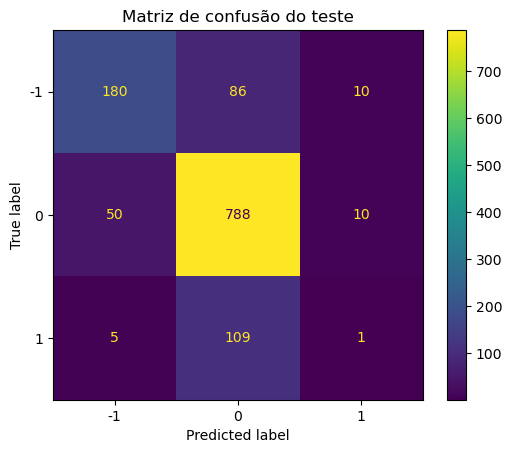

In [168]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

Certos: 504 de 1239
Accuracy: 40.68%
Classe -1:  92.7536231884058 %
Classe 0:  28.066037735849058 %
Classe 1:  8.695652173913043 %


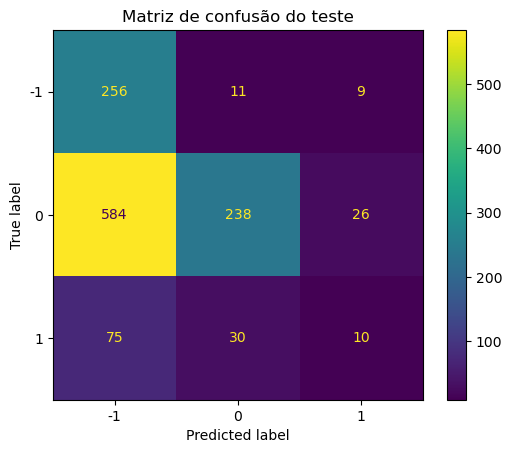

In [169]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto2']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto2']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto2'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()

In [170]:
'''import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

certos = (test_df['classe'] == test_df['Previsto3']).sum()
total = len(test_df)
print(f'Certos: {certos} de {total}')
print(f'Accuracy: {certos/total:.2%}')

for c in classes:
    linhas_classe = test_df[test_df['classe'] == c]     
    total_classe = len(linhas_classe)
    certos_classe = (linhas_classe['classe'] == linhas_classe['Previsto3']).sum()
    taxa_acerto = certos_classe / total_classe 
    print(f"Classe {c}: ", taxa_acerto*100, "%")

matriz = confusion_matrix(test_df['classe'], test_df['Previsto3'], labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)
disp.plot()
plt.title("Matriz de confusão do teste")
plt.show()'''

'import pandas as pd\nfrom sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay\nimport matplotlib.pyplot as plt\n\ncertos = (test_df[\'classe\'] == test_df[\'Previsto3\']).sum()\ntotal = len(test_df)\nprint(f\'Certos: {certos} de {total}\')\nprint(f\'Accuracy: {certos/total:.2%}\')\n\nfor c in classes:\n    linhas_classe = test_df[test_df[\'classe\'] == c]     \n    total_classe = len(linhas_classe)\n    certos_classe = (linhas_classe[\'classe\'] == linhas_classe[\'Previsto3\']).sum()\n    taxa_acerto = certos_classe / total_classe \n    print(f"Classe {c}: ", taxa_acerto*100, "%")\n\nmatriz = confusion_matrix(test_df[\'classe\'], test_df[\'Previsto3\'], labels=classes)\n\ndisp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=classes)\ndisp.plot()\nplt.title("Matriz de confusão do teste")\nplt.show()'